In [21]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [22]:
def get_data(tickers):  
    prices_df = pd.DataFrame()
    columns_names = []

    for ticker in tickers:
        df = yf.download(ticker, auto_adjust=True, start="2010-1-1", end="2015-1-1")
        new_column = df['Close']
        prices_df = pd.concat([prices_df, new_column], axis=1)
        columns_names.append(ticker)
    prices_df.columns = columns_names
    return prices_df

df = get_data(['DIS', 'XLI'])
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,DIS,XLI
2010-01-04 00:00:00,27.933920,21.969965
2010-01-05 00:00:00,27.864237,22.047535
2010-01-06 00:00:00,27.716166,22.094082
2010-01-07 00:00:00,27.724874,22.334576
2010-01-08 00:00:00,27.768421,22.691427


In [23]:
df.shape


(1258, 2)

In [24]:
#nu dynamische hedge ratio elke 20 dagen
lookback = 20
hedgeratios = np.array([])

for i in range(df.shape[0]):
    if i < lookback-1:
        hedgeratios = np.append(hedgeratios, np.NaN)
    else:
        temporary = df.iloc[i-lookback+1:i+1]

        y = temporary['DIS'].tolist()
        x = temporary['XLI'].tolist()

        x = sm.add_constant(x)

        results = sm.OLS(y, x).fit()
        hedgeratios = np.append(hedgeratios, results.params[1])
        

df['hedgeratios'] = hedgeratios
df.head()
    
    
    

,DIS,XLI,hedgeratios
2010-01-04 00:00:00,27.933920,21.969965,NaN
2010-01-05 00:00:00,27.864237,22.047535,NaN
2010-01-06 00:00:00,27.716166,22.094082,NaN
2010-01-07 00:00:00,27.724874,22.334576,NaN
2010-01-08 00:00:00,27.768421,22.691427,NaN


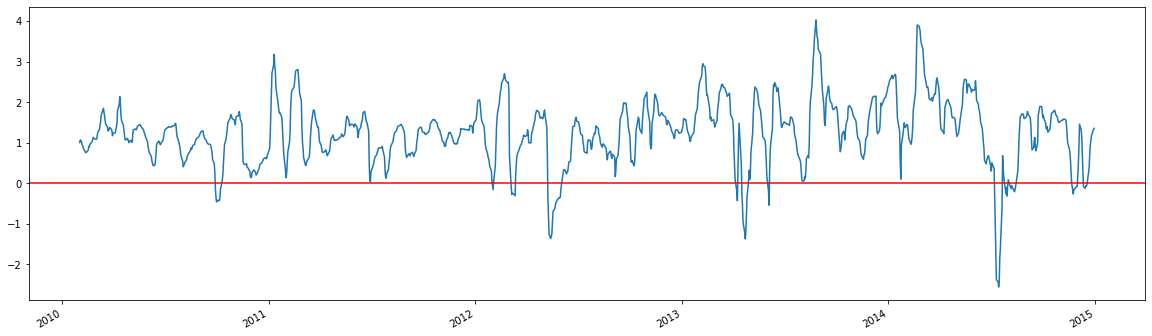

In [25]:
df['hedgeratios'].plot(figsize=(20,6))
plt.axhline(0, c='r')
plt.show()

In [26]:
df['spread'] = df['DIS'] - df['XLI']*df['hedgeratios']
df.dropna(inplace=True)
df.head()

,DIS,XLI,hedgeratios,spread
2010-02-01 00:00:00,25.712795,21.558800,1.003070,4.087818
2010-02-02 00:00:00,26.113470,21.969965,1.064465,2.727218
2010-02-03 00:00:00,26.784161,21.838068,1.063534,3.558640
2010-02-04 00:00:00,25.843451,21.194187,1.033663,3.935812
2010-02-05 00:00:00,25.730217,21.101093,0.967413,5.316747


In [27]:
df['zscores'] = (df['spread'] - df['spread'].rolling(20).mean()) / df['spread'].rolling(20).std()
df.dropna(inplace=True)
df.head()

,DIS,XLI,hedgeratios,spread,zscores
2010-03-01 00:00:00,27.472275,22.668154,1.085781,2.859620,-1.037066
2010-03-02 00:00:00,27.768421,22.706947,1.088541,3.050976,-0.931441
2010-03-03 00:00:00,27.559378,22.737976,1.087891,2.822948,-1.019405
2010-03-04 00:00:00,28.369432,22.846586,1.164097,1.773782,-1.326618
2010-03-05 00:00:00,28.935604,23.195684,1.253981,-0.151352,-1.778214


<AxesSubplot:>

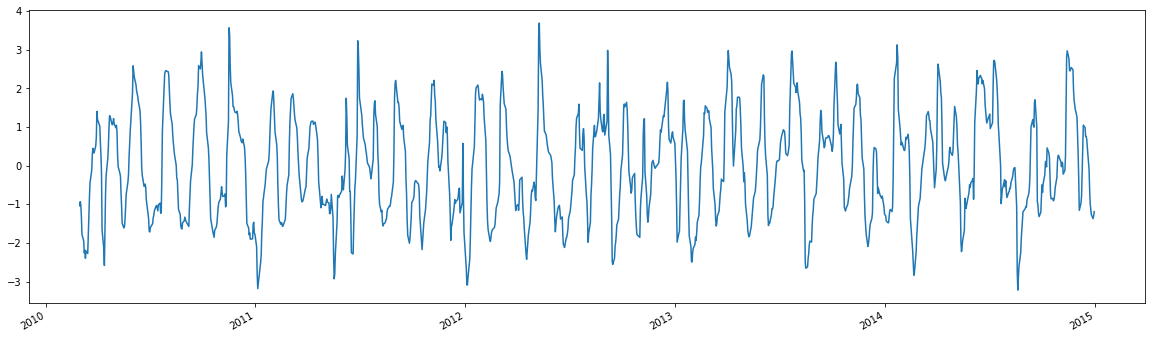

In [28]:
df['zscores'].plot(figsize=(20,6))

In [29]:
import statsmodels.tsa.stattools as ts

adf = ts.adfuller(df['zscores'])
print(f'ADF:{adf}')

ADF:(-10.65205085634449, 4.634224985524707e-19, 11, 1208, {'1%': -3.4357748759345768, '5%': -2.8639355566269677, '10%': -2.5680454348767596}, 734.302837610714)
